# Hands-on tutorial: Using atom-based g3, dimensionalty reduction, and clustering

- **Notebook: Dimensionality reduction and clustering**
- Needs knowledge from the first Notebook

<hr>

- Material for the Erice [7th Workshop and School on Frontiers in Water Biophysics (FWB)](https://www.waterbiophysics.eu/Main/HomePage)
- EuMINe Training School on Machine Learning in Hydrated Biosystems.
- Sunday, July 6, 2025, Erice, Sicily, Italy.
  - Lecture: 8:45-9:55
  - Hands-on session: 14:45-15:45 (16:05)
- Material by [Mikko Karttunen](https://www.softsimu.net/mikko/) and [Matt Davies](https://www.researchgate.net/profile/Matthew-Davies-48).
- **NOTE:** This notebook is a somewhat experimental. The full procedure will be availabe on GitHub later this summer.
<hr>

## The approach

The previous notebook introduced the $g_3$ correlation function in the context of traditional $g(r)$ pair distribution function, and established the relation between them. Here,
we extend the use of $g_3$ to ML analysis of structural data. Instead of (trajectory) averaging, we analyze the $g_3$ for each chosen individual atom. That create a high-dimensional space that will be then subjected to dimensionality reduction. The data will be displayed using a similarity matrix, and clustered.

![alt text](./pics/g3_sheets_water.svg)


## Clustering and friends

**Step 1:** Load MDAnalysis and $g_3$ plus some dependencies.
It is assumed that `g3.py` is in directory `./src`

In [2]:
#-- import MDAnalysis & friends, and the functions

import MDAnalysis as mda
import sys
sys.path.append("./src")
from g3 import MixedRadialAngularDistribution as G3
from g3 import generate_similarity_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

**Step 1.1 (optional):** Load a package to make prettier publication quality plots

In [3]:
#-- use seaborn for making the plots a prettier, has font etc definitions
import prettyplot

**Step 2:** Load the trajectory and topology

In [4]:
#-- Read in the files:

topology_file   = './data/spc-oplsaa-cubic-npt-run.gro'
trajectory_file = './data/spc-oplsaa-cubic-npt-run.trr'
u = mda.Universe(topology_file, trajectory_file)

/home/mkarttu/test_erice/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(


**Step 3:** Print out trajectory & other information. If you are not familiar with MDAnalysis, see the following web sites and check the code line-by-line
- [MDAnalysis User Guide](https://userguide.mdanalysis.org/stable/index.html)
- [MDAnalysis Home](https://www.mdanalysis.org)

In [5]:
#-- Print out trajectory & other relevant info including the version of MDAnalysis being used.
#-- There is some reducancy here, but the aim is to be clear

BOLD  = '\033[1m'
B_END = '\033[0m'

print(f"- {BOLD}MDAnalysis version:{B_END}  {mda.__version__}")

print(f"- {BOLD}Trajectory file:{B_END}  {trajectory_file}")
print(f"- {BOLD}Topology file:{B_END}  {topology_file}")

box = u.dimensions
print(f"\n- {BOLD}Box dimensions and angles (Å, deg):{B_END}  {box}")
#print(f"\n- Box dimensions (A, deg): {box}")
ts       = u.trajectory[0]
dt       = u.trajectory.dt
n_frames = len(u.trajectory)

resnames, counts         = np.unique(u.residues.resnames, return_counts=True)
atom_names, atom_counts  = np.unique(u.atoms.names, return_counts=True)
atom_types, types_counts = np.unique(u.atoms.types, return_counts=True)

print(f"- {BOLD}Does the trajectory data have velocities:{B_END}  {'Yes' if hasattr(ts, 'velocities') else 'No'}")
print(f"\n- {BOLD}Total number of atoms:{B_END} {u.atoms.n_atoms}")
print(f"\n- {BOLD}MoleculNotebookar composition{B_END}")
for res, count in zip(resnames, counts):
  print(f"  * {res}: {count} molecules")
print(f"\n- {BOLD}Atom names{B_END} (note the difference between names and types (next lines):")
for name, count in zip(atom_names, atom_counts):
  print(f"  * {name}: {count}")
print(f"\n- {BOLD}Atom types:{B_END}")
for name, count in zip(atom_types, types_counts):
  print(f"  * {name}: {count}") 
    
print(f"\n- {BOLD}Frames:{B_END} {n_frames}")
print(f"- {BOLD}Frame step:{B_END} {dt:.3f} ps ({dt*1000:.1f} fs)")
print(f"- {BOLD}Total time:{B_END} {n_frames*dt:.2f} ps ({n_frames*dt/1000:.3f} ns)")

- MDAnalysis version:  2.9.0
- Trajectory file:  ./data/spc-oplsaa-cubic-npt-run.trr
- Topology file:  ./data/spc-oplsaa-cubic-npt-run.gro

- Box dimensions and angles (Å, deg):  [40. 40. 40. 90. 90. 90.]
- Does the trajectory data have velocities:  Yes

- Total number of atoms: 6486

- MoleculNotebookar composition
  * SOL: 2162 molecules

- Atom names (note the difference between names and types (next lines):
  * HW1: 2162
  * HW2: 2162
  * OW: 2162

- Atom types:
  * H: 4324
  * O: 2162

- Frames: 41
- Frame step: 0.500 ps (500.0 fs)
- Total time: 20.50 ps (0.021 ns)


**Step 4:** This is where the analysis differs from the previous notebook. Unlike what we did in the first Notebook regarding $g_3$, now, we generate $g_3$ for *each atom* in the system.

As before, we still must make the selections for the reference (or central), the neighbor, and then the group which we're interested in (target) plus the cutoff (`r_cut`) which is given in Ångströms. Unlike what we did in the first Notebook regarding $g_3$, now, we generate $g_3$ for *each atom* in the system. In other words, we generate *individual atom* $g_3$s. This can, naturally, be done with selections any of atoms which might represent molecules etc in a more complex system.  After computing individual atom $g_3$s, a similarity matrix of these distributions is generated. 

**Note:** Running the process below over all the 41 frames with 6486 atoms took about 173 seconds on a laptop with AMD Ryzen 7 5800 (8-Core).

In [6]:
#-- Make the atom selections and compute the g3. Computes g3 for each of the individual reference atoms.

from IPython.display import display, HTML  # for percentage counter
import time

#tic = time.perf_counter() # uncomment this and the related lines below if you want to measure the execution time

#-- Create a display area for progress update:

progress_output = display(HTML("Initializing..."), display_id=True)

ref_atom    = 'type O' # below, we loop over all individual reference atoms
neigh_atom  = 'type H' # this picks both HW1 and HW2
target_atom = 'type O'
r_cut       = 5          # radial cutoff in Angstroms

reference   = u.select_atoms(ref_atom)
neighbour   = u.select_atoms(neigh_atom)
target      = u.select_atoms(target_atom)

no_of_atoms = len(reference) 

ds = []
i  = 0

for atom in reference:
    i = i+1
    central_atom = mda.AtomGroup([atom])
    g3 = G3(central_atom,                  # reference atom 
            target,                        # target
            neighbour,                     # neighbor
            r_cut,                         # cutoff in angstrom
            (100, 50))                     # number of angular and radial bins

    g3.run(start = 1,   # skip the first X frames, 
           stop  = 11,  # stop at frame Y 
           step  = 2)   # skipping every Z frames

    dist = g3.distribution.T
    ds.append(dist)                      # a numpy array of shape (Natoms, Nangular bins, Nradial bins)

    progress_output.update(HTML(f"Processed: {i} of {no_of_atoms}"))
    
print('central_atom', central_atom)
#toc = time.perf_counter()
#print(f"Execution time: {toc - tic:0.4f} seconds")

central_atom <AtomGroup [<Atom 6484: OW of type O of resname SOL, resid 2162 and segid SYSTEM>]>


In [7]:
ds   = np.array(ds)  # a numpy array of shape (Natoms, Nangular bins, Nradial bins)
dist = ds
vmax = np.percentile(dist[dist!=0], 90)

**Step 4.1:** Let's check the dimensions of the object distribution. If everything went correctly, there should be a $g_3$ with dimensions `radial bins` $\times$ `angular bins` (note the transpose above) for each of the selections. This corresponds to the picture in the introduction of this notebook.

In [8]:
print("The distribution matrix is of type:",type(dist)) # check the type of the variable dist
print("Check the dimenesions:", dist.shape)
#rows, columns = dist.shape
#print("Rows:", rows)
#print("Columns:", columns)

The distribution matrix is of type: <class 'numpy.ndarray'>
Check the dimenesions: (2162, 50, 100)


Text(0, 0.5, '$\\cos\\Theta$')

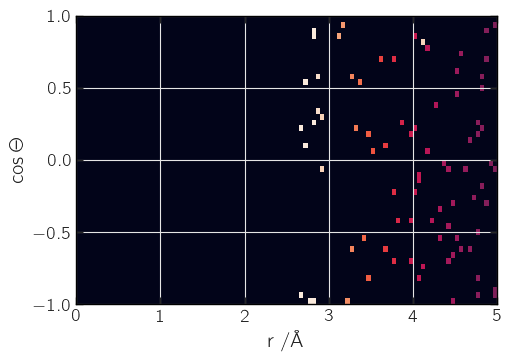

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3.5), constrained_layout=True)
ax.imshow(dist[0,:,:], extent=[0, r_cut, -1, 1], vmax=vmax, aspect='auto', interpolation='none')
ax.set_xlabel('r /\\AA')
ax.set_ylabel(r'$\cos\Theta$')
#fig.savefig('distribution_single.png')
#plt.close()


In [ ]:
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3.5), constrained_layout=True)

**Step:** Generate and plot the similarity matrix.

This can take some time

**Note:** With `r_cut=5` and over all the frames, the process below took about 570 seconds on a laptop with AMD Ryzen 7 5800 (8-Core).You can chose less frames or/and shorter cutoff to make this process faster. 

**Note:** For simplicity, the process below uses PCA, not t-SNE like in the original article.

In [ ]:
tic = time.perf_counter() # uncomment this and the related lines below if you want to measure the execution time

mat = generate_similarity_matrix(ds)
print(mat.min(), mat.mean())
axes[0].imshow(mat)

toc = time.perf_counter()
print(f"Execution time: {toc - tic:0.4f} seconds")

In [29]:
pca = PCA(2).fit_transform(mat)
axes[1].scatter(pca[:,0], pca[:,1], s=1)
axes[1].set_xlabel('PC-1')
axes[1].set_ylabel('PC-2')
fig.savefig('ssimmat.png')

## Tasks

1. Compare the $g_3$ obtained above to the averaged $g_3$ from the previous notebook (for similar selections).
2. The above process would need much more data. If you have a trajectory from your own simulations, try it out.